<a href="https://colab.research.google.com/github/buthaina279/LSTM_MIMIC-III/blob/main/Split_IDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#for google drive
DATA_FILEPATH = "/content/drive/MyDrive/final_project/"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import itertools
from math import floor, ceil
from numpy import random
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(DATA_FILEPATH + 'preprocessed_data.csv',index_col=0) 

In [ ]:
train = pd.read_csv(DATA_FILEPATH + 'train.csv',index_col=0) 
validation = pd.read_csv(DATA_FILEPATH + 'validation.csv',index_col=0) 
test = pd.read_csv(DATA_FILEPATH + 'test.csv',index_col=0) 

In [ ]:
df.head()

,subject_id,hadm_id,icustay_id,age,fullcode_first,dnr_first,fullcode,dnr,cmo_first,cmo_last,...,insurance_Private,insurance_Self Pay,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU
0,3,145834,211552,76,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
1,3,145834,211552,76,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
2,3,145834,211552,76,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
3,3,145834,211552,76,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
4,3,145834,211552,76,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0


##Split the dataset using the "icustay_id"

In [ ]:

import numpy as np

def split_df(df):
  IDs = list(set(df['icustay_id'].tolist())) # get all the time series ID's
  num_samples = len(IDs)
  
# train 
  split_ratio = 0.70
  train_sz = int(split_ratio * num_samples)
  train_sz

  np.random.seed(0)
  train_ids = random.choice(IDs, train_sz, replace=False) # Get random timeseries IDs for train
  group = df.groupby('icustay_id')
  train = []
  for ID in train_ids:
      train_subset = group.get_group(ID)
      train.append(train_subset)
  train = pd.concat(train).reset_index(drop=True)


  remain_ids = [ID for ID in IDs if ID not in train_ids]
  

  #10% validation
  split_ratio = 0.10
  validation_sz = int(split_ratio * num_samples)
  #20% test
  test_sz = num_samples - (train_sz + validation_sz)

  #IDs
  test_ids = remain_ids[:test_sz]
  validation_ids = remain_ids[test_sz:]
  #append to test set
  test = []
  for ID in test_ids:
      test_subset = group.get_group(ID)
      test.append(test_subset)
  test = pd.concat(test).reset_index(drop=True)

  #append to validation set
  validation = []
  for ID in validation_ids:
      validation_subset = group.get_group(ID)
      validation.append(validation_subset)
  validation = pd.concat(validation).reset_index(drop=True)


  print('number of the ICU stay IDs in the whole set',num_samples)

  print("#########################")
  print("train set")
  print("length of ICU stay train IDs ", len(train_ids))
  print('train shape',train.shape)

  print("#########################")
  print("remain IDs for validation and test set ",len(remain_ids))

  print("#########################")
  print("validation set")
  print('length of ICU stay validation IDs',len(validation_ids))
  print('validation shape',validation.shape)

  print("#########################")
  print("test set")
  print('length of ICU stay test IDs',len(test_ids))
  print('test shape',test.shape)

  return train, validation, test, train_ids, validation_ids, test_ids

In [ ]:
train, validation, test, train_ids, validation_ids, test_ids =  split_df(df)

number of the ICU stay IDs in the whole set 28275
#########################
train set
length of ICU stay train IDs  19792
train shape (465471, 80)
#########################
remain IDs for validation and test set  8483
#########################
validation set
length of ICU stay validation IDs 2827
validation shape (66629, 80)
#########################
test set
length of ICU stay test IDs 5656
test shape (133038, 80)


#Check the distribution of the target 

In [ ]:
def check_imbalance(df):
  nnz_df = np.count_nonzero(df['mort_icu']) # class 1 population
  nz_df = len(df['mort_icu']) - nnz_df # class 0 population
  class_0_ratio = 100* (nz_df/ len(df['mort_icu']))
  class_1_ratio = 100* (nnz_df / len(df['mort_icu']))
  print('%0.2f percent of  data belong to the negative class' % class_0_ratio)
  print('%0.2f percent of  data belong to the positive class' % class_1_ratio)

  # Find out imbalance ratio
  imbalance_ratio = nz_df / nnz_df
  print('imbalance ratio: %0.2f' % (imbalance_ratio))

Full dataset

In [ ]:
print("full dataset")
check_imbalance(df)
print("###################################")

full dataset
93.12 percent of  data belong to the negative class
6.88 percent of  data belong to the positive class
imbalance ratio: 13.53
###################################


Text(0.5, 1.0, 'full dataset')

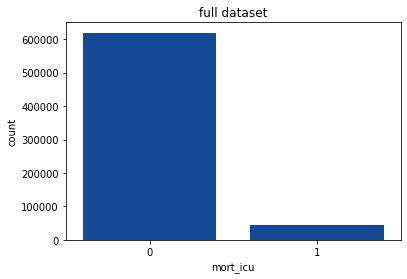

In [ ]:
#plt.tight_layout()
import seaborn as sns
sns.countplot(df['mort_icu'], palette=['#0047AB']).set_title('full dataset')

After split

In [ ]:
print("train set")
check_imbalance(train)

print("###################################")
print("test set")
check_imbalance(test)

print("###################################")
print("validation set")
check_imbalance(validation)

train set
93.00 percent of  data belong to the negative class
7.00 percent of  data belong to the positive class
imbalance ratio: 13.28
###################################
test set
93.42 percent of  data belong to the negative class
6.58 percent of  data belong to the positive class
imbalance ratio: 14.20
###################################
validation set
93.37 percent of  data belong to the negative class
6.63 percent of  data belong to the positive class
imbalance ratio: 14.07


Text(0.5, 1.0, 'train set')

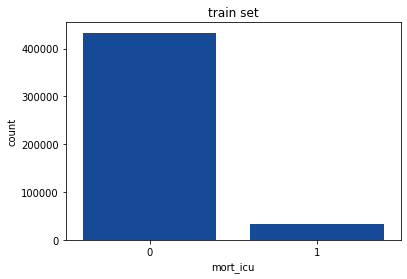

In [ ]:
#plt.tight_layout()
import seaborn as sns
sns.countplot(train['mort_icu'], palette=['#0047AB']).set_title('train set')

Text(0.5, 1.0, 'validation set')

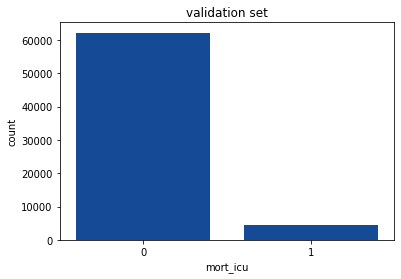

In [ ]:
#plt.tight_layout()
import seaborn as sns
sns.countplot(validation['mort_icu'], palette=['#0047AB']).set_title('validation set')

Text(0.5, 1.0, 'test set')

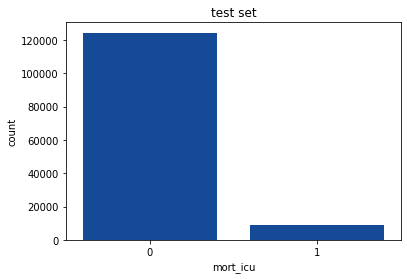

In [ ]:
#plt.tight_layout()
import seaborn as sns
sns.countplot(test['mort_icu'], palette=['#0047AB']).set_title('test set')

##Save output

In [ ]:
train.to_csv(DATA_FILEPATH +'train.csv') # 70%
validation.to_csv(DATA_FILEPATH +'validation.csv') # 10%
test.to_csv(DATA_FILEPATH +'test.csv')# 20%

In [ ]:
#save the IDs
pd.DataFrame(train_ids).to_csv(DATA_FILEPATH +'train_ids.csv') # 70%
pd.DataFrame(validation_ids).to_csv(DATA_FILEPATH +'validation_ids.csv') # 10%
pd.DataFrame(test_ids).to_csv(DATA_FILEPATH +'test_ids.csv') # 20%